# **3D Shapes Dataset**

**Imports**

In [ ]:
# pip install binvox-rw voxels py3dviewer

In [25]:
from matplotlib import pyplot as plt
import numpy as np
import h5py
from PIL import Image
import os


In [33]:
import requests
url = "https://storage.googleapis.com/3d-shapes/3dshapes.h5"
file_name = "3dshapes.h5"
response = requests.get(url)

if response.status_code == 200:
    with open(file_name, 'wb') as file:
        file.write(response.content)
    print(f"File '{file_name}' downloaded successfully.")
else:
    print(f"Failed to download the file. Status code: {response.status_code}")

File '3dshapess.h5' downloaded successfully.


In [34]:
# load dataset
dataset = h5py.File(file_name, 'r')
print(dataset.keys())
images = dataset['images']  # array shape [480000,64,64,3], uint8 in range(256)
labels = dataset['labels']  # array shape [480000,6], float64
image_shape = images.shape[1:]  # [64,64,3]
label_shape = labels.shape[1:]  # [6]
n_samples = labels.shape[0]  # 10*10*10*8*4*15=480000

_FACTORS_IN_ORDER = ['floor_hue', 'wall_hue', 'object_hue', 'scale', 'shape',
                     'orientation']
_NUM_VALUES_PER_FACTOR = {'floor_hue': 10, 'wall_hue': 10, 'object_hue': 10,
                          'scale': 8, 'shape': 4, 'orientation': 15}

<KeysViewHDF5 ['images', 'labels']>


In [35]:
# methods for sampling unconditionally/conditionally on a given factor
def get_index(factors):
  """ Converts factors to indices in range(num_data)
  Args:
    factors: np array shape [6,batch_size].
             factors[i]=factors[i,:] takes integer values in
             range(_NUM_VALUES_PER_FACTOR[_FACTORS_IN_ORDER[i]]).

  Returns:
    indices: np array shape [batch_size].
  """
  indices = 0
  base = 1
  for factor, name in reversed(list(enumerate(_FACTORS_IN_ORDER))):
    indices += factors[factor] * base
    base *= _NUM_VALUES_PER_FACTOR[name]
  return indices


def sample_random_batch(batch_size):
  """ Samples a random batch of images.
  Args:
    batch_size: number of images to sample.

  Returns:
    batch: images shape [batch_size,64,64,3].
  """
  indices = np.random.choice(n_samples, batch_size)
  ims = []
  for ind in indices:
    im = images[ind]
    im = np.asarray(im)
    ims.append(im)
  ims = np.stack(ims, axis=0)
  ims = ims / 255. # normalise values to range [0,1]
  ims = ims.astype(np.float32)
  return ims.reshape([batch_size, 64, 64, 3])


def sample_batch(batch_size, fixed_factor, fixed_factor_value, seed_value=42):
  """ Samples a batch of images with fixed_factor=fixed_factor_value, but with
      the other factors varying randomly.
  Args:
    batch_size: number of images to sample.
    fixed_factor: index of factor that is fixed in range(6).
    fixed_factor_value: integer value of factor that is fixed
      in range(_NUM_VALUES_PER_FACTOR[_FACTORS_IN_ORDER[fixed_factor]]).

  Returns:
    batch: images shape [batch_size,64,64,3]
  """
  factors = np.zeros([len(_FACTORS_IN_ORDER), batch_size],
                     dtype=np.int32)
  np.random.seed(seed_value)
  for factor, name in enumerate(_FACTORS_IN_ORDER):
    num_choices = _NUM_VALUES_PER_FACTOR[name]
    factors[factor] = np.random.choice(num_choices, batch_size)
  factors[fixed_factor] = fixed_factor_value
  indices = get_index(factors)
  ims = []
  for ind in indices:
    im = images[ind]
    im = np.asarray(im)
    ims.append(im)
  ims = np.stack(ims, axis=0)
  ims = ims / 255. # normalise values to range [0,1]
  ims = ims.astype(np.float32)
  return ims.reshape([batch_size, 64, 64, 3])

In [36]:
def show_images_grid(imgs_, num_images=25):
  ncols = int(np.ceil(num_images**0.5))
  nrows = int(np.ceil(num_images / ncols))
  _, axes = plt.subplots(ncols, nrows, figsize=(nrows * 3, ncols * 3))
  axes = axes.flatten()

  for ax_i, ax in enumerate(axes):
    if ax_i < num_images:
      ax.imshow(imgs_[ax_i], cmap='Greys_r', interpolation='nearest')
      ax.set_xticks([])
      ax.set_yticks([])
    else:
      ax.axis('off')

In [37]:
def convert_to_voxels(images):
    # Define voxel parameters (adjust these as needed)
    voxel_size = (32, 32, 32)  # Voxel size in each dimension
    threshold = 0.5  # Threshold value for voxelization

    voxel_data = []
    for img in images:
        # Assuming each image represents a binary object, you may need to adjust the threshold
        binary_img = img.mean(axis=2) > threshold

        # Create a Voxels object from the binary image
        voxel = Voxels.from_binary_array(binary_img, size=voxel_size)
        voxel_data.append(voxel)

    return voxel_data

IndexError: index 10 is out of bounds for axis 0 with size 10

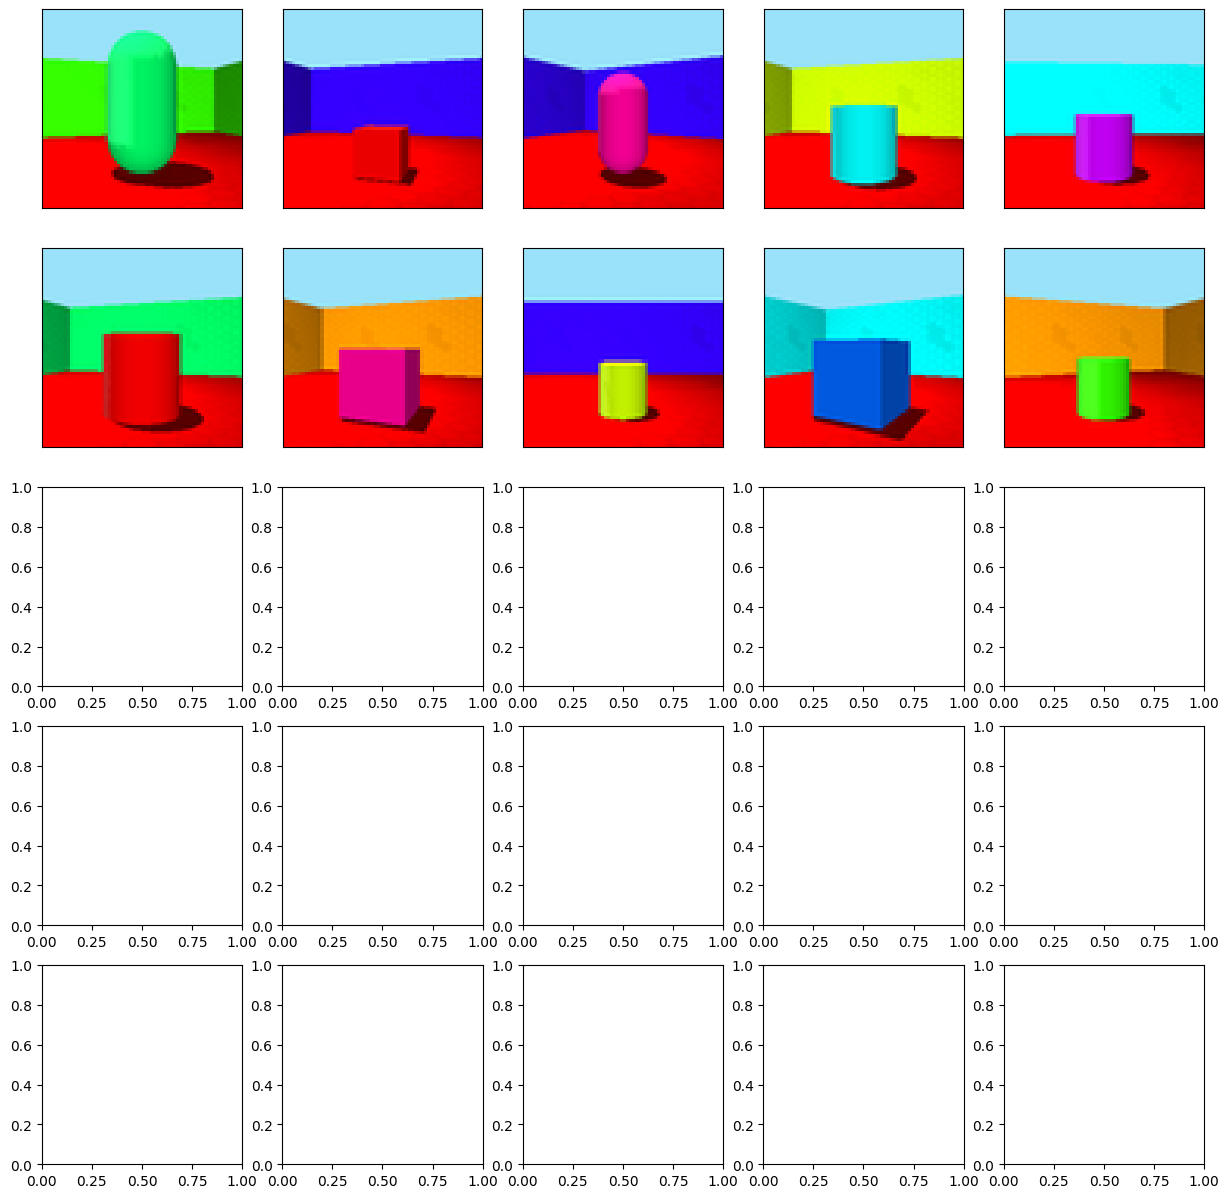

In [39]:
batch_size = 1000
fixed_factor_str = 'floor_hue' #@param ['floor_hue', 'wall_hue', 'object_hue', 'scale', 'shape', 'orientation']
fixed_factor_value = 0  # first value of floor hue - red
fixed_factor = _FACTORS_IN_ORDER.index(fixed_factor_str)  # floor hue
seed = 42
img_batch = sample_batch(batch_size, fixed_factor, fixed_factor_value, seed)

show_images_grid(img_batch)

In [30]:
def save_images_as_png(images, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    for i, image in enumerate(images):
        image = (image * 255).astype(np.uint8)
        pil_image = Image.fromarray(image)
        file_name = os.path.join(output_folder, f"{i}.png")
        pil_image.save(file_name)

In [31]:
output_folder = 'dataset/images'
save_images_as_png(img_batch, output_folder)